# 使用Diffusers官方接口使用

 双目标-效果较好

In [ ]:
import torch
from diffusers import StableDiffusionAttendAndExcitePipeline

pipe = StableDiffusionAttendAndExcitePipeline.from_pretrained(
    "G:/code/model/stable-diffusion-v1-4", torch_dtype=torch.float16
).to("cuda")


prompt = "a cat and a frog"


In [ ]:

# use get_indices function to find out indices of the tokens you want to alter
pipe.get_indices(prompt)


In [5]:

# 需要手动指定
token_indices = [2, 5]
seed = 6141
generator = torch.Generator("cuda").manual_seed(seed)

images = pipe(
    prompt=prompt,
    token_indices=token_indices,
    guidance_scale=7.5,
    generator=generator,
    num_inference_steps=50,
    max_iter_to_alter=25,
).images

image = images[0]
image.save(f"images/{prompt}_{seed}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

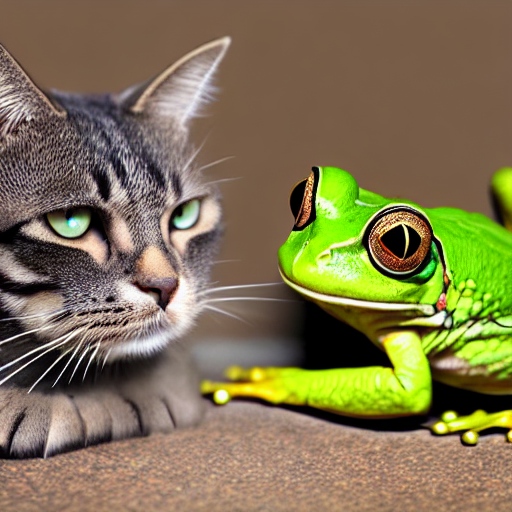

In [7]:
# 多目标保存效果很好
image

多目标——效果比较一般

In [15]:
# 四目标
prompt_2='a cat,a frog,a dog and a bird'
pipe.get_indices(prompt_2)

{0: '<|startoftext|>',
 1: 'a</w>',
 2: 'cat</w>',
 3: ',</w>',
 4: 'a</w>',
 5: 'frog</w>',
 6: ',</w>',
 7: 'a</w>',
 8: 'dog</w>',
 9: 'and</w>',
 10: 'a</w>',
 11: 'bird</w>',
 12: '<|endoftext|>'}

In [12]:
token_indices_2 = [2,5,8,11]
seed = 6141
generator = torch.Generator("cuda").manual_seed(seed)
images = pipe(
    prompt=prompt_2,
    token_indices=token_indices_2,
    guidance_scale=7.5,
    generator=generator,
    num_inference_steps=50,
    max_iter_to_alter=25,
).images

image = images[0]
image.save(f"images/{prompt_2}_{seed}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

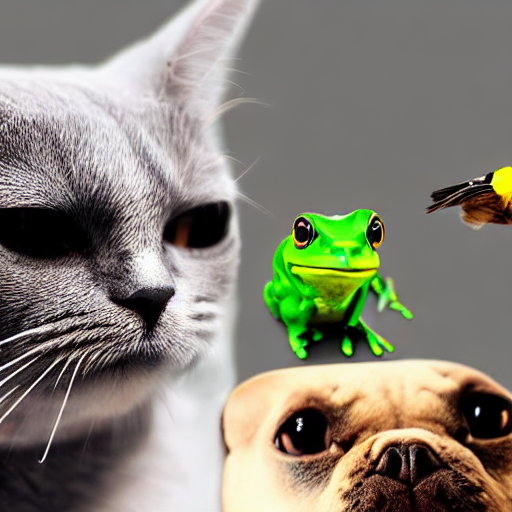

In [13]:
image

In [14]:
# 7目标
prompt_3='a cat,a frog,a dog,a bird,a snake,a horse,a cow'
pipe.get_indices(prompt_3)

{0: '<|startoftext|>',
 1: 'a</w>',
 2: 'cat</w>',
 3: ',</w>',
 4: 'a</w>',
 5: 'frog</w>',
 6: ',</w>',
 7: 'a</w>',
 8: 'dog</w>',
 9: ',</w>',
 10: 'a</w>',
 11: 'bird</w>',
 12: ',</w>',
 13: 'a</w>',
 14: 'snake</w>',
 15: ',</w>',
 16: 'a</w>',
 17: 'horse</w>',
 18: ',</w>',
 19: 'a</w>',
 20: 'cow</w>',
 21: '<|endoftext|>'}

In [16]:
token_indices_3 = [2,5,8,11,14,17,20]
seed = 6141
generator = torch.Generator("cuda").manual_seed(seed)
images = pipe(
    prompt=prompt_3,
    token_indices=token_indices_3,
    guidance_scale=7.5,
    generator=generator,
    num_inference_steps=50,
    max_iter_to_alter=25,
).images

image = images[0]
image.save(f"images/{prompt_3}_{seed}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

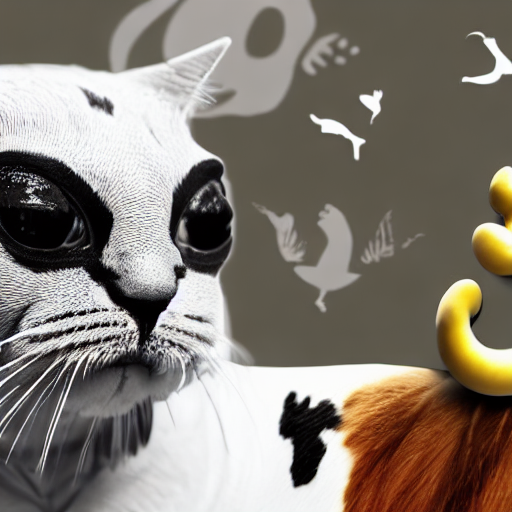

In [17]:
image

测试属性分配

In [19]:
prompt_4="A black and white spotted dog and a light green horse are walking in the desert."
pipe.get_indices(prompt_4)

{0: '<|startoftext|>',
 1: 'a</w>',
 2: 'black</w>',
 3: 'and</w>',
 4: 'white</w>',
 5: 'spotted</w>',
 6: 'dog</w>',
 7: 'and</w>',
 8: 'a</w>',
 9: 'light</w>',
 10: 'green</w>',
 11: 'horse</w>',
 12: 'are</w>',
 13: 'walking</w>',
 14: 'in</w>',
 15: 'the</w>',
 16: 'desert</w>',
 17: '.</w>',
 18: '<|endoftext|>'}

In [22]:
token_indices_4 = [6,11]
seed = 42
generator = torch.Generator("cuda").manual_seed(seed)
images = pipe(
    prompt=prompt_4,
    token_indices=token_indices_4,
    guidance_scale=7.5,
    generator=generator,
    num_inference_steps=50,
    max_iter_to_alter=25,
).images

image = images[0]
image.save(f"images/{prompt_4}_{seed}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

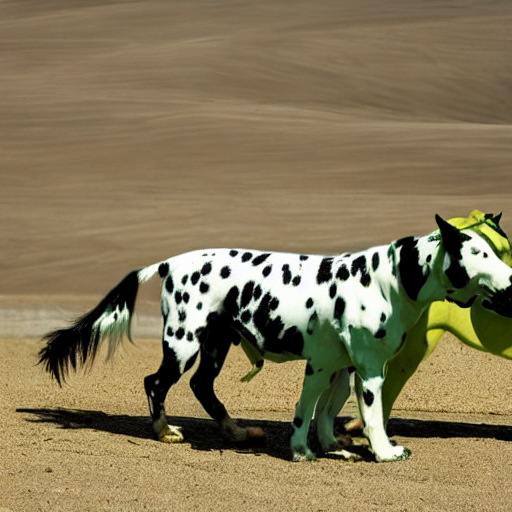

In [24]:
image

- Attend and excite 生成的图片似乎容易出现图像被裁剪，主体显示不完全的问题
- 在简单的双目标小表现还可以，在属性错误分配上很差。
    - 可能是基座模型sd1.4不够强大，下一步可以尝试在sdxl、flux等上面做一下实验


# 高斯模糊/平滑模糊

文章是对单通道的注意力图进行高斯平滑来的，去除高斯噪声，保留边缘信息

In [1]:
# 写一段代码修改pipeline，将高斯模糊改为平均模糊
import sys
sys.path.append(r"C:\Users\Lenovo\Desktop\Paper-recover\Attend-and-Excite\Attend-and-Excite-main")


In [2]:
from pipeline_attend_and_excite import AttendAndExcitePipeline
from utils.gaussian_smoothing import GaussianSmoothing,AverageSmoothing
import inspect
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
import numpy as np
import torch
from torch.nn import functional as F
from packaging import version
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import deprecate, is_accelerate_available, logging,  replace_example_docstring
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from utils.ptp_utils import AttentionStore, aggregate_attention


A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "e:\conda_data\envs\heavy_daily\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


In [3]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

In [4]:
class AttendAndExcitePipelinewithAverageSmoothing(AttendAndExcitePipeline):

    def _compute_max_attention_per_index(self,
                                         attention_maps: torch.Tensor,
                                         indices_to_alter: List[int],
                                         smooth_attentions: bool = False,
                                         sigma: float = 0.5,
                                         kernel_size: int = 3,
                                         normalize_eot: bool = False) -> List[torch.Tensor]:
        """ 重写计算每个token最大注意力值的方法，使用平均平滑替代高斯平滑 """
        last_idx = -1
        if normalize_eot:
            prompt = self.prompt
            if isinstance(self.prompt, list):
                prompt = self.prompt[0]
            last_idx = len(self.tokenizer(prompt)['input_ids']) - 1
        attention_for_text = attention_maps[:, :, 1:last_idx]
        attention_for_text *= 100
        attention_for_text = torch.nn.functional.softmax(attention_for_text, dim=-1)

        # Shift indices since we removed the first token
        indices_to_alter = [index - 1 for index in indices_to_alter]

        # Extract the maximum values
        max_indices_list = []
        for i in indices_to_alter:
            image = attention_for_text[:, :, i]
            if smooth_attentions:
                input = F.pad(image.unsqueeze(0).unsqueeze(0), (1, 1, 1, 1), mode='reflect')
                smoother = AverageSmoothing(channels=1, kernel_size=kernel_size, dim=2)
                image = smoother(input).squeeze(0).squeeze(0)
            max_indices_list.append(image.max())
        return max_indices_list

NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipelinewithAverageSmoothing.from_pretrained(pretrained_model_name_or_path="g:code/model/stable-diffusion-v1-4",
                                                variant='fp16',
                                                torch_dtype=torch.float16).to(device)
tokenizer = stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# configurable parameters (see RunConfig for all parameters)
# scale factor- intensity of shift by gradient
# thresholds- a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    
    # 确保模型和权重使用相同的数据类型
    with torch.autocast(device_type='cuda', enabled=False):
        image = run_on_prompt(model=stable,
                              prompt=prompts,
                              controller=controller,
                              token_indices=indices_to_alter,
                              seed=generator,
                              config=config)
    if display_output:
        display(image)
    return image

In [10]:
prompt = "an dog with a crown"
seeds = [21]

In [11]:
token_indices = get_indices_to_alter(stable, prompt)

{1: 'an', 2: 'dog', 3: 'with', 4: 'a', 5: 'crown'}
Altering tokens: ['dog', 'crown']


In [12]:
torch.cuda.empty_cache()

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.7051
Iteration 1 | Loss: 0.4966
Iteration 2 | Loss: 0.5083
Iteration 3 | Loss: 0.3716
Iteration 4 | Loss: 0.1846
Iteration 5 | Loss: 0.0986
Iteration 6 | Loss: 0.0396
Iteration 7 | Loss: 0.1069
Iteration 8 | Loss: 0.0420
Iteration 9 | Loss: 0.0815
Iteration 10 | Loss: 0.0474
Iteration 11 | Loss: 0.0605
Iteration 12 | Loss: 0.0522
Iteration 13 | Loss: 0.0737
Iteration 14 | Loss: 0.0566
Iteration 15 | Loss: 0.0581
Iteration 16 | Loss: 0.0654
Iteration 17 | Loss: 0.0596
Iteration 18 | Loss: 0.0601
Iteration 19 | Loss: 0.0654
Iteration 20 | Loss: 0.0796
Iteration 21 | Loss: 0.0757
Iteration 22 | Loss: 0.0879
Iteration 23 | Loss: 0.0889
Iteration 24 | Loss: 0.0957


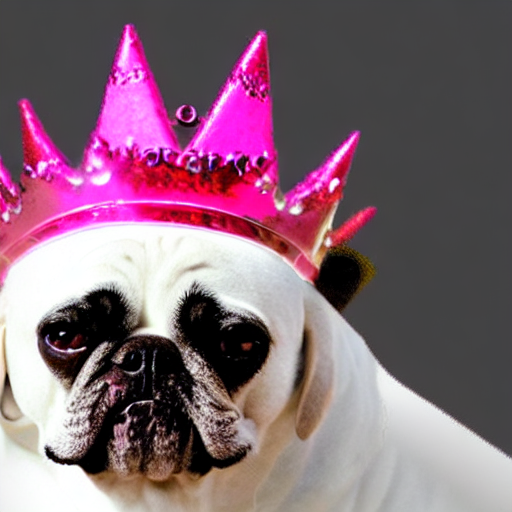

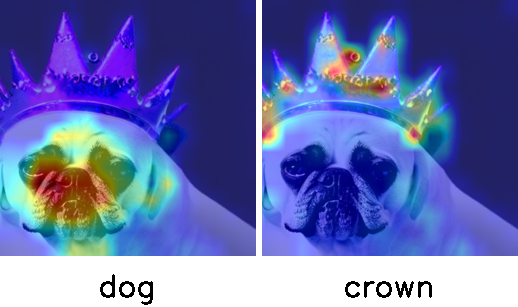

In [13]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

In [17]:
prompt = "a cat with a or2,9ange hat and an dog with a crown"
seeds = [42]
token_indices = get_indices_to_alter(stable, prompt)

{1: 'a',
 2: 'cat',
 3: 'with',
 4: 'a',
 5: 'orange',
 6: 'hat',
 7: 'and',
 8: 'an',
 9: 'dog',
 10: 'with',
 11: 'a',
 12: 'crown'}
Altering tokens: ['cat', 'dog']


In [18]:
torch.cuda.empty_cache()

C:\Users\Lenovo\Desktop\Paper-recover\Attend-and-Excite\Attend-and-Excite-main\pipeline_attend_and_excite.py:486: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.9395
Iteration 1 | Loss: 0.9028
Iteration 2 | Loss: 0.9033
Iteration 3 | Loss: 0.8486
Iteration 4 | Loss: 0.8423
Iteration 5 | Loss: 0.7510
Iteration 6 | Loss: 0.3770
Iteration 7 | Loss: 0.4697
Iteration 8 | Loss: 0.5889
Iteration 9 | Loss: 0.3462
Iteration 10 | Loss: 0.4609
Iteration 11 | Loss: 0.2866
Iteration 12 | Loss: 0.3452
Iteration 13 | Loss: 0.3579
Iteration 14 | Loss: 0.2769
Iteration 15 | Loss: 0.2729
Iteration 16 | Loss: 0.2808
Iteration 17 | Loss: 0.2437
Iteration 18 | Loss: 0.2603
Iteration 19 | Loss: 0.2358
	 Try 1. dog has a max attention of 0.787109375
	 Try 2. hat has a max attention of 0.78857421875
	 Try 3. hat has a max attention of 0.81640625
	 Finished with loss of: 0.1650390625
Iteration 20 | Loss: 0.1650
Iteration 21 | Loss: 0.1729
Iteration 22 | Loss: 0.1704
Iteration 23 | Loss: 0.1875
Iteration 24 | Loss: 0.2305


e:\conda_data\envs\heavy_daily\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


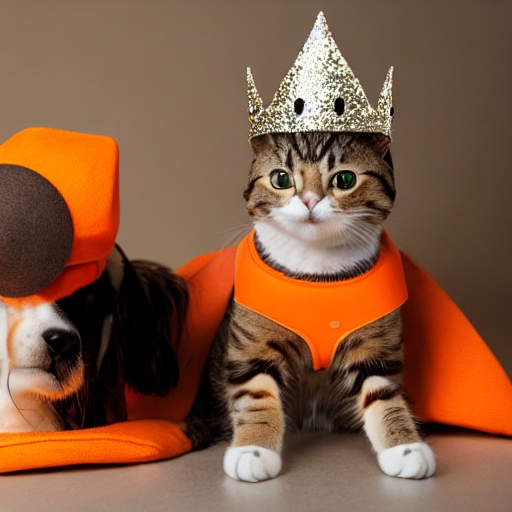

In [16]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)

属性分配错误，生成的狗发生崎变，效果差

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.9395
Iteration 1 | Loss: 0.9028
Iteration 2 | Loss: 0.9033
Iteration 3 | Loss: 0.8486
Iteration 4 | Loss: 0.6670
Iteration 5 | Loss: 0.4761
Iteration 6 | Loss: 0.6260
Iteration 7 | Loss: 0.2998
Iteration 8 | Loss: 0.4165
Iteration 9 | Loss: 0.2217
Iteration 10 | Loss: 0.2266
Iteration 11 | Loss: 0.1421
Iteration 12 | Loss: 0.1396
Iteration 13 | Loss: 0.1406
Iteration 14 | Loss: 0.1245
Iteration 15 | Loss: 0.1162
Iteration 16 | Loss: 0.0933
Iteration 17 | Loss: 0.0781
Iteration 18 | Loss: 0.0625
Iteration 19 | Loss: 0.0830
Iteration 20 | Loss: 0.1006
Iteration 21 | Loss: 0.0723
Iteration 22 | Loss: 0.0781
Iteration 23 | Loss: 0.1221
Iteration 24 | Loss: 0.1528


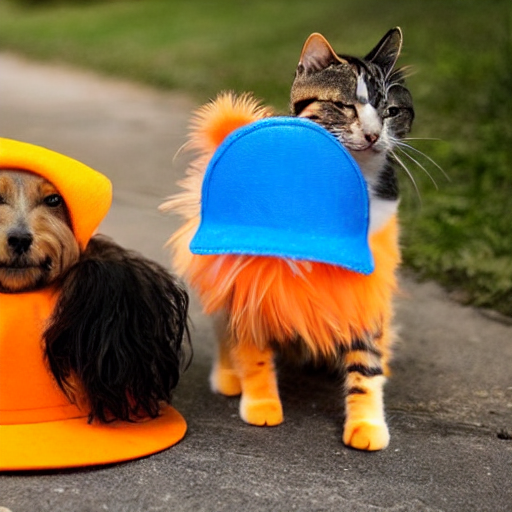

In [19]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)

AverageSmoothing的效果比高斯平滑的效果差一些
